# Logistic Regression
> Building an training the Logistic Regression model on the MNIST dataset
>
> Called a "Regression Model" because we are outputting a real-number for the probability that a given class is true. From here, we can take the class with the maximum probability to be the class for the datapoint (giving the illusion of classification).
>
> **Table of Contents**
>> 1. Import Modules
>>
>> 2. Load Datasets
>>
>> 3. Define Model
>>
>> 4. Define Loss Function and Optimizer
>>
>> 5. Train Model
>>
>> 6. Test Model
>>
>> 7. Save Model

## Import Modules

> Before doing anything, we must import the needed modules

In [159]:
#Torch Library needed for Machine Learning
import torch

#TorchVision needed to import image dataset and perform image transformations (into tensors)
import torchvision

#matplotlib.pyplot for plotting the loss function
import matplotlib.pyplot as plt

#time for computing how long the model takes to train
import time

## Load Datasets

> Now that we have imported our modules, we must load the data we want to work with
>
> We will load two datasets: Train and Test (specified by the dataset's "train" parameter)
>
> Step 1 is to download the data onto our local drive

In [160]:
#Download and make a reference to the training dataset
training_dataset = torchvision.datasets.MNIST(root="./data",
                                              train=True,
                                              transform=torchvision.transforms.ToTensor(),
                                              download=True)

#Download and make a reference to the training dataset
#Note: The data is already downloaded via the first command (dont need to set the download parameter as true)
testing_dataset = torchvision.datasets.MNIST(root="./data",
                                             train=False,
                                             transform=torchvision.transforms.ToTensor(),
                                             download=True)

> Step 2: With the Data downloaded and referenced, we can properly load the data to be read via the DataLoader class
>
> We will also specify a hyperparameter for how to split the data into subsets when reading (known as the batch_size)

In [161]:
#Specify the hyperparameter for the batch size
#Batch Size: number of datapoints read in the backpropogation algorithm to compute the gradient
batch_size = 100 #read 100 datapoints at a time, then update parameters

#Define how to input the training data via the DataLoader
#Note: we are not dropping the last batch, so the last batch is not guarenteed to consist of 100 images (it will have <= 100 images)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=False)

#Define how to input the testing data via the DataLoader
#Note: We will not shuffle the testing data. We could if we want to, but not shuffling can help for comparing the loss of differently trained models (not too sure if that is a valid reason though)
testing_loader = torch.utils.data.DataLoader(dataset=testing_dataset,
                                            batch_size = batch_size,
                                            shuffle=False,
                                            drop_last=False)

## Define Model

> The next step is the define which machine learning model to use
>
> The logistic regression model is the softmax function applied to a linear model, so we need to sequntially apply each module
>
> **What is the difference between sigmoid and softmax?**
>> Sigmoid = 1/(1+exp(-x))
>>
>> Softmax_i = exp(x_i)/(Sum{j=0->n}(exp(x_j)))
>>
>> Sigmoid is a special case of softmax for when we have a single output value. In the case of a single output, the output value can be thought of as being reltive to a value of 0 for the alternative class.
>>
>> In this case, we can derive the sigmoid function from the softmax by assuming we have an output of z in a binary classsification problem.
>>
>> Output: z -> Interpreted as: [z, 0]
>>
>> Probability of class with output z being the correct class = Softmax on [z, 0]
>> 
>> = exp(z)/(exp(z)+exp(0)) 
>>
>> = exp(z)/(exp(z)+1) 
>>
>> = exp(z)/(exp(z)+1)*(exp(-z)/exp(-z)) 
>>
>> = 1/(1+exp(-z))
>
> Since the Logistic Regresssion model has multiple components, we must define a class to specify the sequence which these modules act on the data
>
> For actual implementation, it is better to use the LogSoftmax function as stated on the PyTorch documentation (https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html). This is stated for numerical stability and can also be argued to be useful since it would reduce the number of computations (cancelling out operations when applying logs and exponentials)

In [162]:
#Must create a class to define the sequence which the modules act on the input data for the logistic regression model
class LogisticRegression(torch.nn.Module):
    #Define the structure of the model in its constructor
    def __init__(self, input_size, num_classes):
        #We first want to call the constructor of the parent class of the LogisticRegression class (torch.nn.Module) on this specific instance of the class
        super(LogisticRegression, self).__init__()
        #Next we will define a sequence of operations to act on the data (need to define a ModuleList so PyTorch can recognize the torch.nn modules in a list a get the model parameters)
        #For Logistic Regression Model: Linear Model -> Softmax
        self.layers = torch.nn.ModuleList(
            [
                torch.nn.Linear(input_size, num_classes), #Linear Model
                torch.nn.Softmax(dim=1) #Softmax along the output column vector (for a better model, recommended to use LogSoftmax)
            ]
        )

    #Define the forward propogation procedure for the model
    def forward(self, x):
        #Create variable "out" to store the output of the forward propogation
        out = x
        #Iterate over each layer in the model
        for layer in self.layers:
            out = layer(out)
        #ensure the the output requires use of the gradient for backpropogation
        out.requires_grad_()
        #return the output of the model on the data
        return(out)

> Now that we have defined the class for our Logistic Regression model, we can instantiate it
>
> Before instatiating our model, we must first define 2 hyperparameters: input_size and num_classes (output_size)

In [163]:
#Specify the hyperparameter for the input and number of classes for the model
input_size = 28*28 #For 28x28 sized image (each pixel will be an input)
num_classes = 10 #We are determining if an image is a number 0-9 (10 digits total to choose from)

#Instantiate the logistic regresssion model
model = LogisticRegression(input_size, num_classes)

> There is an alternative approach for defining the logistic regression model
>
> If we have the softmax function be applied as part of our loss function, then we can define our model as simply a linear regression model. This would work out well because our parameters for the logistic regression model are only present within the module for the linear regression model
>
> The Crosss Entropy Loss function computes softmax and the negtive log loss together
>
> This method would be more efficient because the softmax uses exponentials and the log function applied to it would lead to cancelling out some computations (and also reduces overflow). For educational purposes, we will define both models and compare their training time

In [164]:
#Specify the hyperparameter for the input and number of classes for the model
input_size = 28*28 #For 28x28 sized image (each pixel will be an input)
num_classes = 10 #We are determining if an image is a number 0-9 (10 digits total to choose from)

#Define the Optimized Logistic Regression Model
#Only specify the Linear Regression model; the softmax will get applied as part of the loss function
model_optimized = torch.nn.Linear(input_size, num_classes)

## Define Loss Function and Optimizer

> For our defined model, since we have a multi-class output (>3 class probability vector) then the loss will be computed using the negative log likelihood loss function
>
> **What is the difference between the Negative Log Likelihood Loss function and the Cross Entropy Loss function?**
>>
>> Similar to the discussion about the sigmoid and the softmax, the cross entropy loss function is the binary classification case of the negative log likelihood function (https://stats.stackexchange.com/questions/198038/cross-entropy-or-log-likelihood-in-output-layer)
>>
>> However, in PyTorch, the negative log likelihood (NLL) and the cross entropy (CE) are 2 different functions (https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81)
>>
>> As stated on the PyTorch documentation (https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) and a blog by J. D. McCaffrey (https://jamesmccaffrey.wordpress.com/2020/10/28/the-pytorch-nllloss-function-doesnt-compute-anything/), the NLL Loss function expects the values passed to be log-probabilities. So we will need to apply the log function before passing values into the loss function
>>
>> As for the CE Loss function, it expects the raw outputs (known as logits) to be passed to the function so that it can apply the softmax function itself

In [165]:
#Define the loss function for the logistic regression model
lossFunction = torch.nn.NLLLoss() #Note: the loss function is assuming log-probabilities are passed

> We can also define the losss function for our optimized model

In [166]:
#Since our optimized model will be passing outputing logits, then we need to use the Cross Entropy Loss function
lossFunction_optimizedModel = torch.nn.CrossEntropyLoss() #The Cross Entropy Loss function computes the softmax of the input along with the negative log likelihood

> With our loss function defined, we will now define the optimizer responsible for updating the parameters
>
> The optimizer used will be stochastic gradient descent (SGD) which approximates the gradient by taking a subset of the read data points
>
> We will also need to define another hyperparameter for the learning rate (step size) of our optimizer

In [167]:
#Define the hyperparameter for the step size of the SGD optimizer
step_size = 0.001

#Define the optimizer as using SGD
optimizer = torch.optim.SGD(model.parameters(), lr=step_size)

> We will also need to define the hyperparameters and the optimizer for our optimized model

In [168]:
#Define the hyperparameter for the step size of the SGD optimizer
step_size = 0.001

#Define the optimizer as using SGD
optimizer_optimizedModel = torch.optim.SGD(model_optimized.parameters(), lr=step_size)

## Train Model

> Now that we have loaded the data as well as defined the Model, Loss Function, and Optimizer, we can start the train the model
>
> However, before we begin, we must specify one last hyperparameter: the num_epoch
>
> num_epoch: the number of epochs which is essentially the number of times to iterate over the entire dataset until we stop training (updating the parameters)

Epoch [1/5], Step [100/600], Loss: 2.2579615116119385
Epoch [1/5], Step [200/600], Loss: 2.136193037033081
Epoch [1/5], Step [300/600], Loss: 2.0453946590423584
Epoch [1/5], Step [400/600], Loss: 1.9647504091262817
Epoch [1/5], Step [500/600], Loss: 1.8947731256484985
Epoch [1/5], Step [600/600], Loss: 1.805185079574585
Epoch [2/5], Step [100/600], Loss: 1.7052888870239258
Epoch [2/5], Step [200/600], Loss: 1.6783255338668823
Epoch [2/5], Step [300/600], Loss: 1.6441951990127563
Epoch [2/5], Step [400/600], Loss: 1.5480841398239136
Epoch [2/5], Step [500/600], Loss: 1.4543054103851318
Epoch [2/5], Step [600/600], Loss: 1.4499382972717285
Epoch [3/5], Step [100/600], Loss: 1.4479376077651978
Epoch [3/5], Step [200/600], Loss: 1.3986167907714844
Epoch [3/5], Step [300/600], Loss: 1.3219658136367798
Epoch [3/5], Step [400/600], Loss: 1.2508999109268188
Epoch [3/5], Step [500/600], Loss: 1.3547626733779907
Epoch [3/5], Step [600/600], Loss: 1.2996902465820312
Epoch [4/5], Step [100/600], L

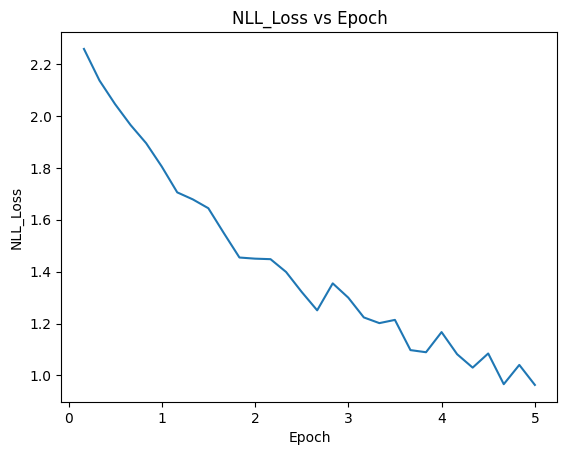

In [169]:
#Define the hyperparamter for num_epochs
#num_epochs: the number of times to iterate over the entire dataset
num_epochs = 5

#Now we can begin the training process
#First, we will save a constant for the number of steps (dataset/batch_size)
total_steps = len(training_loader)

#Start timer to see how much time it takes to train the model
start_time = time.time()
#Store x and y values to make a plot of the loss
x = list()
y = list()
#Loop for each epoch
for epoch in range(num_epochs):
    #Loop for each batch
    for i, (images, labels) in enumerate(training_loader):
        #Reshape images to a feature matrix: row = image features; column = pixel value of images in the batch
        #Since the batch_size is not guarenteed to be the same for the final batch, we will let python infer the dimension (i.e., put -1 in the batch_size dimension)
        images = images.reshape(-1, input_size)
        
        #Perform Forward propogation
        outputs = model(images)

        #Compute the loss of the current model outputs (remember we need to take the log of the probabilites)
        outputs = torch.log(outputs)
        loss = lossFunction(outputs, labels)

        #Prepare for Backward propogation by reseting the gradient for the optimizer
        optimizer.zero_grad()
        #Perform Backward propogation to acquire the gradient
        loss.backward()
        #Take a step to update the parameters of the model
        optimizer.step()

        #Every 100 steps, print/save the data
        if((i+1)%100 == 0):
            #Print the output of the current point in training for the model and its current loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item()}")
            #Save the data to plot
            x.append(epoch + i/total_steps)
            y.append(loss.item())

#Stop the timer
stop_time = time.time()

#Compute and print the total training time
print(f"It took {(stop_time - start_time)/60} minutes to train this model")

#Print the loss as a function of the epochs
plt.plot(x, y)
plt.title("NLL_Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("NLL_Loss")
plt.show()

> We can also train the optimized version of the model

Epoch [1/5], Step [100/600], Loss: 2.2074079513549805
Epoch [1/5], Step [200/600], Loss: 2.1206705570220947
Epoch [1/5], Step [300/600], Loss: 2.0164754390716553
Epoch [1/5], Step [400/600], Loss: 1.9492123126983643
Epoch [1/5], Step [500/600], Loss: 1.8557138442993164
Epoch [1/5], Step [600/600], Loss: 1.8170804977416992
Epoch [2/5], Step [100/600], Loss: 1.7679640054702759
Epoch [2/5], Step [200/600], Loss: 1.703092336654663
Epoch [2/5], Step [300/600], Loss: 1.6003893613815308
Epoch [2/5], Step [400/600], Loss: 1.644710898399353
Epoch [2/5], Step [500/600], Loss: 1.5342351198196411
Epoch [2/5], Step [600/600], Loss: 1.5236129760742188
Epoch [3/5], Step [100/600], Loss: 1.3532451391220093
Epoch [3/5], Step [200/600], Loss: 1.3789808750152588
Epoch [3/5], Step [300/600], Loss: 1.3520370721817017
Epoch [3/5], Step [400/600], Loss: 1.2955094575881958
Epoch [3/5], Step [500/600], Loss: 1.224042534828186
Epoch [3/5], Step [600/600], Loss: 1.3042072057724
Epoch [4/5], Step [100/600], Loss:

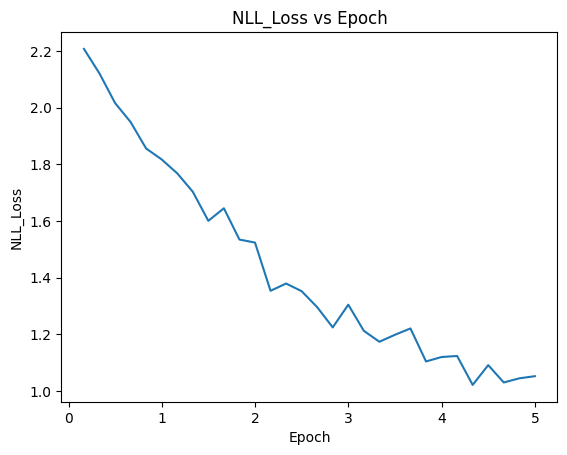

In [170]:
#Define the hyperparamter for num_epochs
#num_epochs: the number of times to iterate over the entire dataset
num_epochs = 5

#Now we can begin the training process
#First, we will save a constant for the number of steps (dataset/batch_size)
total_steps = len(training_loader)

#Start timer to see how much time it takes to train the model
start_time = time.time()
#Store x and y values to make a plot of the loss
x = list()
y = list()
#Loop for each epoch
for epoch in range(num_epochs):
    #Loop for each batch
    for i, (images, labels) in enumerate(training_loader):
        #Reshape images to a feature matrix: row = image features; column = pixel value of images in the batch
        #Since the batch_size is not guarenteed to be the same for the final batch, we will let python infer the dimension (i.e., put -1 in the batch_size dimension)
        images = images.reshape(-1, input_size)
        
        #Perform Forward propogation
        outputs = model_optimized(images)

        #Compute the loss of the current model outputs (remember we need to take the log of the probabilites)
        loss = lossFunction_optimizedModel(outputs, labels)

        #Prepare for Backward propogation by reseting the gradient for the optimizer
        optimizer_optimizedModel.zero_grad()
        #Perform Backward propogation to acquire the gradient
        loss.backward()
        #Take a step to update the parameters of the model
        optimizer_optimizedModel.step()

        #Every 100 steps, print/save the data
        if((i+1)%100 == 0):
            #Print the output of the current point in training for the model and its current loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item()}")
            #Save the data to plot
            x.append(epoch + i/total_steps)
            y.append(loss.item())

#Stop the timer
stop_time = time.time()

#Compute and print the total training time
print(f"It took {(stop_time - start_time)/60} minutes to train this model")

#Print the loss as a function of the epochs
plt.plot(x, y)
plt.title("NLL_Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("NLL_Loss")
plt.show()

## Test Model

> Now that we have trained our model, we can test it with data it has never seen before
>
> Since we are only getting the predictions of the models when testing and not updating the paramters, we can turn off AutoGrad for memory efficiency

In [171]:
#Test the model without computing any gradients
with torch.no_grad():
    #Create counter variables to store the total number of items the model gets correct
    total = 0
    correct = 0
    #Loop through each test batch
    for images, labels in testing_loader:
        #resize the images from the batch to a data matrix of dimensions (batch_size, imput_size)
        images = images.reshape(-1, input_size) #since the batch_size is not a constant, allow the correct dimension to be inferred from the data (via -1 in dimension)
        
        #Perform forward propogation with the testing input
        outputs = model(images)

        #Set the preicted class as the index with the max probability
        values, predictions = torch.max(outputs.data, dim=1) #look along the columns of the output matrix

        #Add to the count of the total predictions
        total += labels.size(dim=0)
        #Add to the count of the total number correct (the total number of times the labels match at the same index)
        correct += (predictions == labels).sum()
    
    #Print the accurcy of the classification
    print(f"Accuracy of the model on 10,000 test images: {(correct/total)*100}%")

Accuracy of the model on 10,000 test images: 82.9000015258789%


> We can also test the optimized model
>
> We expect the classification accuracy to be the same (neglecting some small variance from training) because the "optimized" portion of the model was only for the expected increase to the speed of training

In [172]:
#Test the model without computing any gradients
with torch.no_grad():
    #Create counter variables to store the total number of items the model gets correct
    total = 0
    correct = 0
    #Loop through each test batch
    for images, labels in testing_loader:
        #resize the images from the batch to a data matrix of dimensions (batch_size, imput_size)
        images = images.reshape(-1, input_size) #since the batch_size is not a constant, allow the correct dimension to be inferred from the data (via -1 in dimension)
        
        #Perform forward propogation with the testing input
        outputs = model_optimized(images)

        #Set the preicted class as the index with the max probability
        values, predictions = torch.max(outputs.data, dim=1) #look along the columns of the output matrix

        #Add to the count of the total predictions
        total += labels.size(dim=0)
        #Add to the count of the total number correct (the total number of times the labels match at the same index)
        correct += (predictions == labels).sum()
    
    #Print the accurcy of the classification
    print(f"Accuracy of the optimized model on 10,000 test images: {(correct/total)*100}%")

Accuracy of the optimized model on 10,000 test images: 83.20999908447266%


## Save Model

> Now that we have successfully trained our model and tested to ensure that everything is correct, we can save the trained model to share or use in a program

In [173]:
#Save the initial trained model
torch.save(model.state_dict(), "model.ckpt")

#save the optimized trained model
torch.save(model_optimized.state_dict(), "model_optimized.ckpt")